# Introduction to PINNs

Before taking a look at the PINNs, let's start from artificial neural networks (ANN).

Here you will learn:
* the architecture of neural networks
* implementation the neural networks in PyTorch
* how to train and evaluate the neural networks

In [1]:
# firstly, we import the necessary libraries
import os
import time

os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

import torch
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.random import set_random_seed

# Set random seed to make results reproducible
set_random_seed(12)


d:\Projects\AI4S


## Define the NN model

In [9]:
class FCN(nn.Module):
    
    def __init__(self, layers):
        """
        Params:
            layers: a list that specifies the number of neurons in each layer. e.g. [1, 20, 20, 2]
        """
        super().__init__() #call __init__ from parent class 

        self.activation = nn.Tanh() # activation function
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)]) # Initialise neural network as a list using nn.Modulelist
        self.iter = 0
        
        # Xavier Normal Initialization
        for i in range(len(layers) - 1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)


    def forward(self, x):
        for i in range(len(self.linears) - 2):
            x = self.linears[i](x)
            x = self.activation(x)
            
        x = self.linears[-1](x)
        return x


## Generate training/testing data

Here we take the sine function as an example, and randomly split train and test datasets.

torch.Size([500, 1]) torch.Size([500, 1])


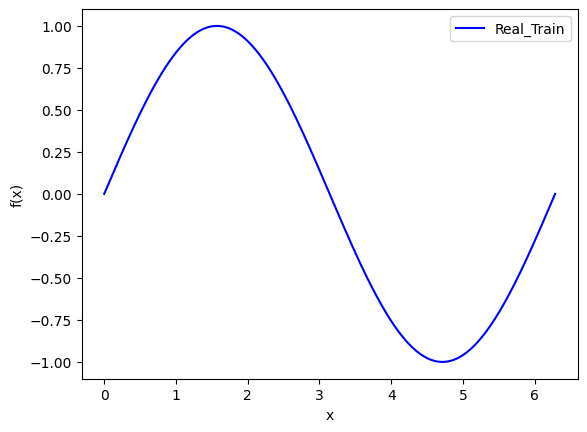

In [3]:
x = torch.linspace(0, 2 * np.pi, 500).view(-1, 1)
y = torch.sin(x)

print(x.shape, y.shape)

fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(), y.detach().numpy(), color='blue', label='Real_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')

In [5]:
indices = np.arange(500)

train_idx, test_idx, _, _ = train_test_split(indices, indices, test_size=0.2, random_state=42)

x_train = x[train_idx]
y_train = y[train_idx]
x_test = x[test_idx]
y_test = y[test_idx]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([400, 1]) torch.Size([400, 1])
torch.Size([100, 1]) torch.Size([100, 1])


## Train Neural Network

FCN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)
Epoch 10, loss = 0.42828348
Epoch 20, loss = 0.37217852
Epoch 30, loss = 0.34816879
Epoch 40, loss = 0.31955966
Epoch 50, loss = 0.29422179
Epoch 60, loss = 0.27101794
Epoch 70, loss = 0.24902400
Epoch 80, loss = 0.22881080
Epoch 90, loss = 0.21018513
Epoch 100, loss = 0.19326417
Epoch 110, loss = 0.17805412
Epoch 120, loss = 0.16458350
Epoch 130, loss = 0.15284315
Epoch 140, loss = 0.14279377
Epoch 150, loss = 0.13435046
Epoch 160, loss = 0.12738258
Epoch 170, loss = 0.12172031
Epoch 180, loss = 0.11716661
Epoch 190, loss = 0.11351365
Epoch 200, loss = 0.11056030
Epoch 210, l

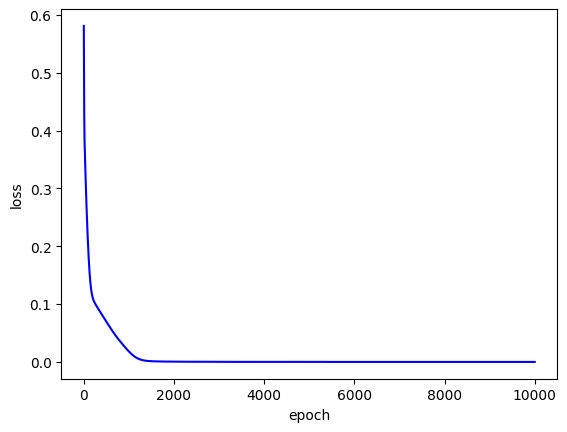

In [23]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set default dtype to float32
torch.set_default_dtype(torch.float)

x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
x_test = x_test.float().to(device)
y_test = y_test.float().to(device)

# define the model
layers = np.array([1, 50, 50, 20, 50, 50, 1]) # 5 hidden layers
model = FCN(layers).to(device) # the model and the data must be in the same device
print(model)

# define the training parameters
lr = 1e-4
epoch = 10000

# define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)
loss_fun = nn.MSELoss(reduction ='mean') # loss function

# define a loss list to record the loss
loss_list = []

# start training
for i in range(1, epoch+1):

    optimizer.zero_grad()

    y_output = model(x_train)
    loss = loss_fun(y_output, y_train)

    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

    if i % 10 == 0:
      print(f"Epoch {i}, loss = {loss.item():.8f}")

fig, ax = plt.subplots()
ax.plot(np.arange(1, epoch+1), np.array(loss_list), color='blue', label='loss')
ax.set_xlabel('epoch',color='black')
ax.set_ylabel('loss',color='black')
ax.tick_params(axis='y', color='black')

## Test

In [28]:
y_output_test = model(x_test).to(device)
loss_of_test = loss_fun(y_output_test, y_test)
print(loss_of_test.item())

1.624498395358387e-06


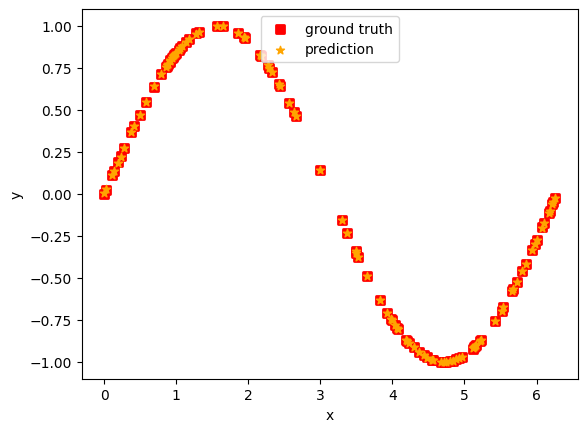

In [41]:
_, indices = torch.sort(x_test.squeeze(1))
x_test_plot = x_test[indices]
y_test_plot = y_test[indices]
yh_test_plot = y_output_test[indices]

fig, ax = plt.subplots()
ax.scatter(x_test_plot.detach().cpu().numpy(), y_test_plot.detach().cpu().numpy(),
           marker='s', linewidths=2, color='red', label='ground truth')
ax.scatter(x_test_plot.detach().cpu().numpy(), yh_test_plot.detach().cpu().numpy(),
           marker='*', linewidths=1, color='orange', label='prediction')
ax.set_xlabel('x',color='black')
ax.set_ylabel('y',color='black')
ax.tick_params(axis='y', color='black')
ax.legend(loc = 'upper center')